# SpaceNet EDA Begins
- You can check Observation at the bottom of the notebook.

## Installing Dependincies and Importinf libraries

In [63]:
%%capture
!pip install boto3
!pip install awscli
!pip install --upgrade awscli
!pip install rasterio
!pip install geopandas
!pip install boto3
!pip3 install folium
!pip install selenium

In [64]:
import json
import os
import PIL
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import boto3
import folium
from folium import plugins

## Accessing AWS acount and downloading the sample dataset

In [ ]:
  # Enter aws user credentials
with open('/content/drive/MyDrive/config/credentials.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)
#get username and key
access_key = str(obj['aws_access_key_id'])
secret_key = str(obj['aws_secret_access_key'])
default_region = str(obj['aws_default_region'])
# 
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
os.environ['AWS_DEFAULT_REGION'] = default_region

In [ ]:
# List the data directory on AWS
!aws s3 ls 's3://spacenet-dataset/spacenet/SN4_buildings/' --human-readable --summarize

                           PRE sample/
                           PRE tarballs/
                           PRE test_public/
                           PRE train/

Total Objects: 0
   Total Size: 0 Bytes


In [ ]:
# Download the samples
%%capture
!aws s3 cp 's3://spacenet-dataset/spacenet/SN4_buildings/sample/' SpaceNetSample/ --recursive 

## Visualizing the Images 

- There are three resolution for each image. We are exploring the MS ans SPAN to determine which has the best resolution.

In [71]:
# Helper functions for visualization
def visualize(list_images):
    """PLot images in row X columns"""
    n = len(list_images)
    fig=plt.figure(figsize=(25, 25))
    columns = 3
    rows = np.ceil(n/columns)
    for i, image in enumerate(list_images):
        fig.add_subplot(rows, columns, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)
    plt.show()
# Create RGB version for the images
def get_rgb(raster_img):
  '''
  takes a path contaioning mas image 
  and returns the rgb version
  '''
  red = rio.open(raster_img).read(5) 
  green = rio.open(raster_img).read(3) 
  blue = rio.open(raster_img).read(2) 

  rgb = np.dstack((red, green, blue))
  # normalize and convert to range 0-255
  rgb = ((rgb - rgb.min()) / (rgb.max() - rgb.min()) * 255).astype('uint8')
  return rgb


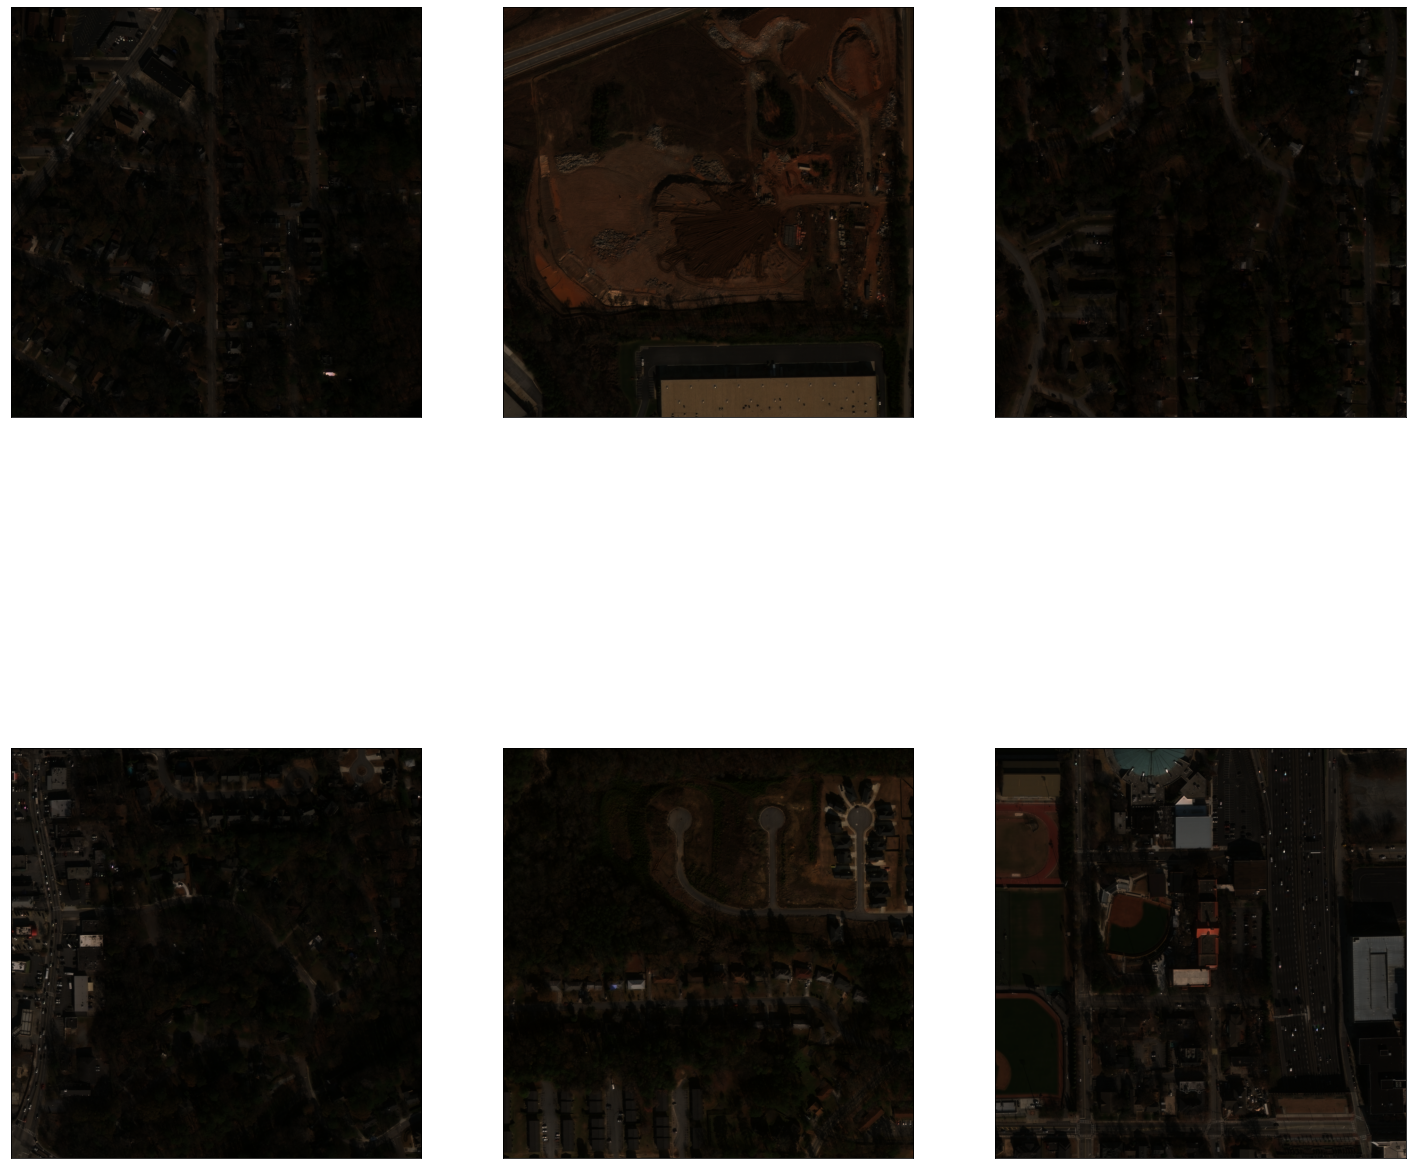

In [70]:
# For the first Image folder
root = '/content/SpaceNetSample/Atlanta_nadir7_catid_1030010003D22F00'
img_root = os.path.join(root, 'Pan-Sharpen')
imgs = []
for img in sorted(os.listdir(img_root)):
  img = get_rgb(os.path.join(img_root, img))
  imgs.append(img)

# Inspect the images
visualize(imgs[5:11])

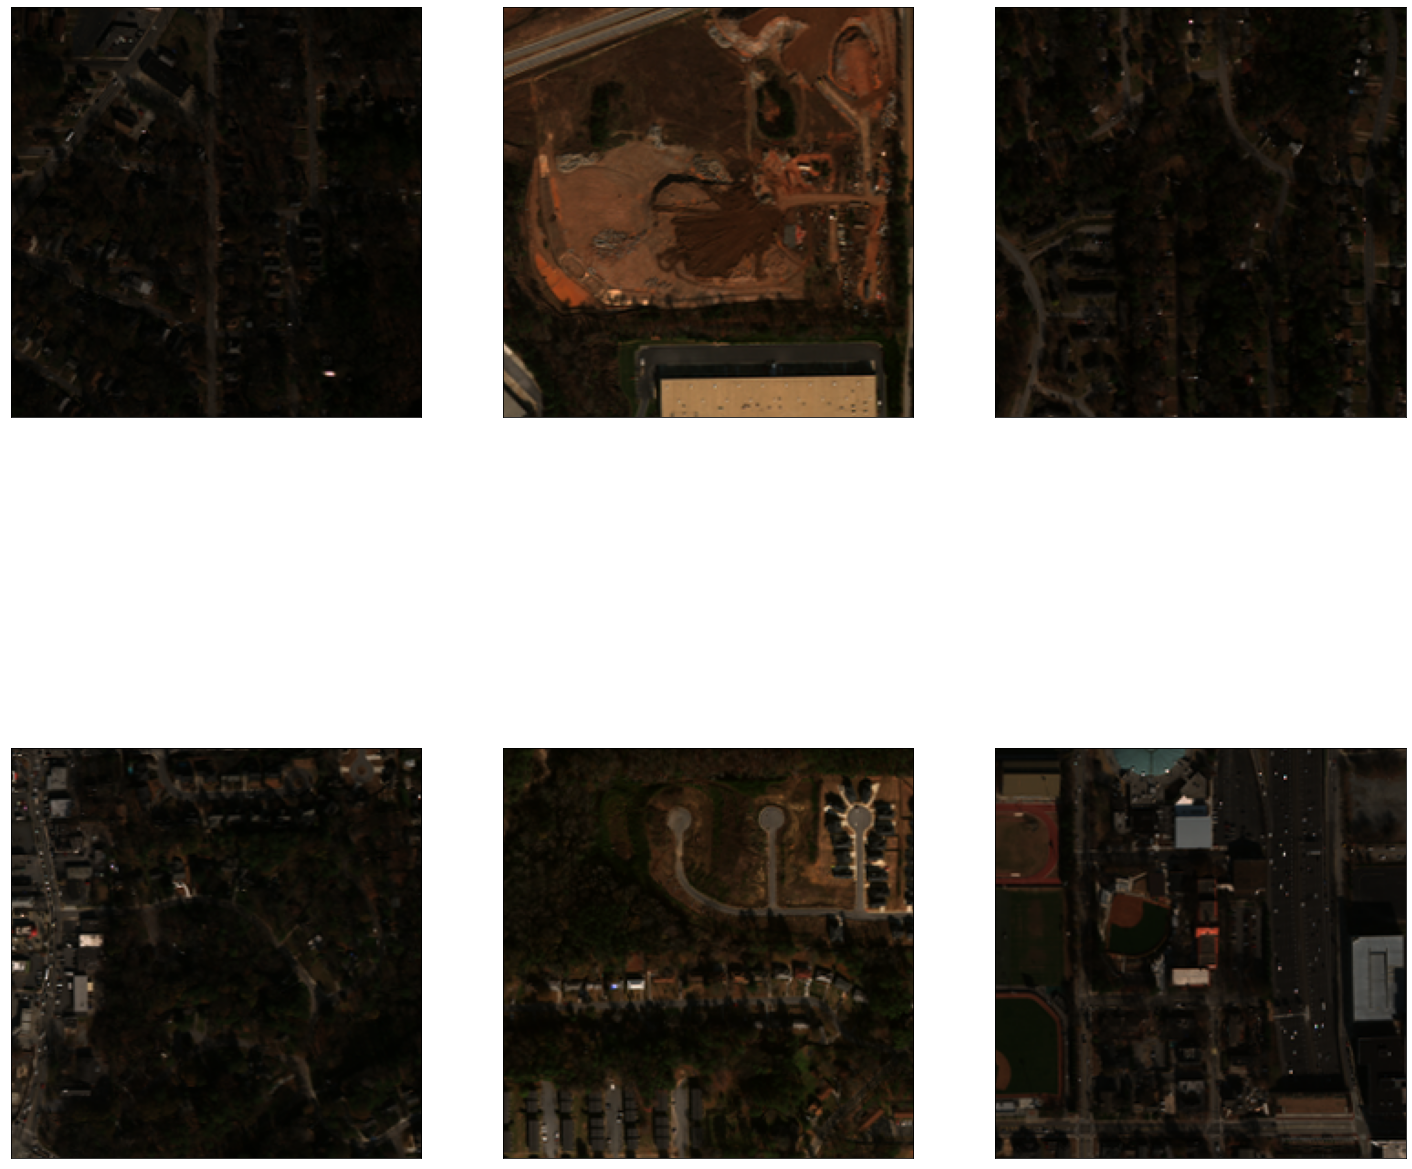

In [72]:
img_root = os.path.join(root, 'MS')
imgs = []
for img in sorted(os.listdir(img_root)):
  img = get_rgb(os.path.join(img_root, img))
  imgs.append(img)

# Inspect the images
visualize(imgs[5:11])

## Data Structure:
- For each image we have 27 version, divided into 27 folders **(ex. Atlanta_nadir34_catid_10300*, Atlanta_nadir10_catid_10300*, Atlanta_nadir52_catid_10300*)**. 
These are taken from different nadir angles (nadir, off nadir, very off nadir).
- We have MS (multi-spectral) , PAN (panchromatic), and Sharpen PAN images.


In [ ]:
# Get the number of bands for ms and mas and pan images
ms_img = rio.open('/content/SpaceNetSample/Atlanta_nadir10_catid_1030010003993E00/MS/MS_Atlanta_nadir10_catid_1030010003993E00_741251_3742239.tif')
ms_img.bounds

BoundingBox(left=741251.0, bottom=3742239.0, right=741701.0, top=3742689.0)

In [ ]:
num_bands = len(ms_img.descriptions)
print(f"Number of bands in MS image: {num_bands}")
# Tha bands are: Coastal, Blue, Green, Yellow, Red, Red Edge, 
# Near Infrared 1 (NIR1), and Near Infrared 2 (NIR2)

Number of bands in MS image: 8


Number of bands 1
Image dimenssion: 900X900 pixel


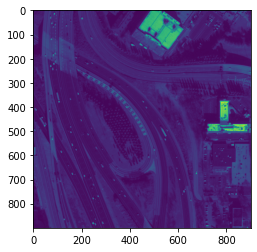

In [ ]:
# Read the PAN version
pan_img = rio.open('/content/SpaceNetSample/Atlanta_nadir10_catid_1030010003993E00/PAN/PAN_Atlanta_nadir10_catid_1030010003993E00_741251_3742239.tif')
num_bands = len(pan_img.descriptions)
print(f"Number of bands {num_bands}")
print(F"Image dimenssion: {pan_img.height}X{pan_img.width} pixel")
plt.imshow(pan_img.read(1))


Number of bands for the Sharpen Pans4


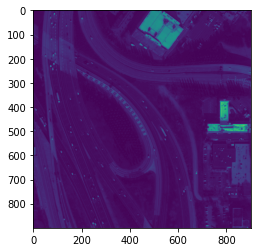

In [ ]:
# Read the SPAN version (Low-res color bands + High-res grayscale band = Hi-res color image)
span_img = rio.open('/content/SpaceNetSample/Atlanta_nadir10_catid_1030010003993E00/Pan-Sharpen/Pan-Sharpen_Atlanta_nadir10_catid_1030010003993E00_741251_3742239.tif')
num_bands = len(span_img.descriptions)
print(f"Number of bands for the Sharpen Pans{num_bands}")
plt.imshow(span_img.read(1))

In [73]:
'''span_img.descriptions'''

'span_img.descriptions'

## Explore Tragets

In [ ]:
target = gpd.read_file('/content/SpaceNetSample/geojson/spacenet-buildings/spacenet-buildings_741251_3742239.geojson')

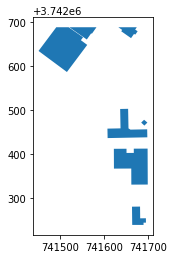

In [ ]:
target.plot()

In [ ]:
target.head(2)

,access,addr_house,addr_hou_1,addr_inter,admin_leve,aerialway,aeroway,amenity,area,barrier,bicycle,boundary,brand,bridge,building,constructi,covered,culvert,cutting,denominati,disused,embankment,foot,generator_,harbour,highway,historic,horse,intermitte,junction,landuse,layer,leisure,lock,man_made,military,motorcar,name,natural,office,oneway,operator,osm_id,place,population,power,power_sour,public_tra,railway,ref,religion,route,service,shop,sport,surface,tags,toll,tourism,tower_type,tunnel,water,waterway,wetland,width,wood,z_order,tracktype,way_area,origarea,origlen,partialDec,truncated,geometry
0,,,,,,,,,,,,,,,yes,,,,,,,,,,,,,,,,,,,,,,,,,,,,64337,,,,,,,,,,,,,,"""security:classification""=>""UNCLASSIFIED"",""sou...",,,,,,,,,,-999999,,-999999.0,1403.518386,0,0.662212,1,"POLYGON ((741664.218 3742280.510, 741682.523 3..."
1,,,,,,,,,,,,,,,yes,,,,,,,,,,,,,,,,,,,,,,,,,,,,82370,,,,,,,,,,,,,,"""security:classification""=>""UNCLASSIFIED"",""sou...",,,,,,,,,,-999999,,-999999.0,4674.967321,0,1.000000,0,"POLYGON ((741622.921 3742412.274, 741651.690 3..."


In [ ]:
# The location on the folium map is off. will look into it
'''# Plot the sample images on the map  (This case only 20 )
data_dir = '/content/SpaceNetSample/Atlanta_nadir10_catid_1030010003993E00/MS/'
m = folium.Map(location=[3743589.0, 739901.0], tiles='cartodbpositron',zoom_start=9)
for filename in os.listdir(data_dir):
  ds = rio.open(data_dir + "/" + filename)
  cord_1 = ds.bounds[1] 
  cord_2 = ds.bounds[2]
  # Add the coordinates to our map
  folium.Marker(location=[cord_1,  cord_2],popup='Default popup Marker1',tooltip='Click here to see Popup').add_to(m)
  # Close the image
  ds.close()
  
m


'''

'# Plot the sample images on the map  (This case only 20 )\ndata_dir = \'/content/SpaceNetSample/Atlanta_nadir10_catid_1030010003993E00/MS/\'\nm = folium.Map(location=[3743589.0, 739901.0], tiles=\'cartodbpositron\',zoom_start=9)\nfor filename in os.listdir(data_dir):\n  ds = rio.open(data_dir + "/" + filename)\n  cord_1 = ds.bounds[1] \n  cord_2 = ds.bounds[2]\n  # Add the coordinates to our map\n  folium.Marker(location=[cord_1,  cord_2],popup=\'Default popup Marker1\',tooltip=\'Click here to see Popup\').add_to(m)\n  # Close the image\n  ds.close()\n  \nm\n\n\n'

In [74]:
'''import os
import folium

m = folium.Map([37, 0], zoom_start=1, tiles="stamentoner")
merc = os.path.join(data_dir, "MS_Atlanta_nadir10_catid_1030010003993E00_733601_3724689.tif")


if not os.path.isfile(merc):
    print(f"Could not find {merc}")
else:
    ds = rio.open(merc)
    img = folium.raster_layers.ImageOverlay(
        name="Mercator projection SW",
        image=merc,
        bounds=ds.bounds,
        opacity=0.6,
        interactive=True,
        cross_origin=False,
        zindex=1,
    )

    folium.Popup("I am an image").add_to(img)

    img.add_to(m)
    folium.LayerControl().add_to(m)

m'''

'import os\nimport folium\n\nm = folium.Map([37, 0], zoom_start=1, tiles="stamentoner")\nmerc = os.path.join(data_dir, "MS_Atlanta_nadir10_catid_1030010003993E00_733601_3724689.tif")\n\n\nif not os.path.isfile(merc):\n    print(f"Could not find {merc}")\nelse:\n    ds = rio.open(merc)\n    img = folium.raster_layers.ImageOverlay(\n        name="Mercator projection SW",\n        image=merc,\n        bounds=ds.bounds,\n        opacity=0.6,\n        interactive=True,\n        cross_origin=False,\n        zindex=1,\n    )\n\n    folium.Popup("I am an image").add_to(img)\n\n    img.add_to(m)\n    folium.LayerControl().add_to(m)\n\nm'

# Observations: 
- We can use Sharpen_Pan images  for training as it is higher (spatial) resolution than the MS version.
- The Sharpen_Pan comes from merging the high resolution PAN and bands from the lower resolution MS version to increase resolution

- When a building is covered by a tree, the target ignore that part of the roof. This could pose an issue when calculating the area. On a second thought, this area already can't be used for installing solar panals.

- Obviously the Sharpen pan  images have better resolution and features looking more sharp.

## Calculate the area
In the follwoing I'm only calculating the area of the building.
If we need to calculate the area for the roof, we need to find the pitch.
roof_area = building_area X roof_pitch

In [ ]:
# Calculate the area for each polygon-->next we need to calculate the pitch to ge t the area for the roof

# Get the projection
target.crs # EPSG:32616 which is in meter
cp_target = target.copy()
# The area in square meter
cp_target["area"] = cp_target['geometry'].area
#cp_target.head()

In [ ]:
print(f"Number of buildings: {len(cp_target)}")
print(f"the data projection: {cp_target.crs}")
cp_target[["access", "area"]]


Number of buildings: 7
the data projection: epsg:32616


,access,area
0,,929.426502
1,,4674.967321
2,,2610.506489
3,,93.220915
4,,6480.053996
5,,609.668984
6,,863.626838


## Update Projection

In the follwing I'm trying to explore the possibility to change the projectiop of the [Microsoft US buildings footprints GeoJson](https://github.com/microsoft/USBuildingFootprints) to match the SapceNet projection.
Assumption:
Maybe we can use it to label other images that we find.

In [ ]:
gdf = gpd.read_file('/content/NorthDakota.geojson')
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
gdf_reproject = gdf.copy()
gdf_reproject = gdf_reproject.to_crs(epsg=32616)

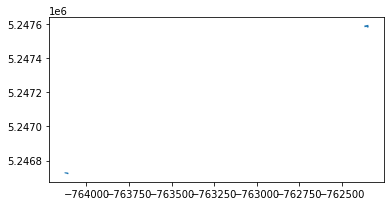

In [ ]:
gdf_reproject[559100: 559102].plot()


#Reference:
- [Getting Started with SapceNet dataset](https://sumit-arora.medium.com/getting-started-with-aws-spacenet-and-spacenet-dataset-visualization-basics-7ddd2e5809a2)


- https://spacenet.ai/off-nadir-building-detection/
- https://spacenetchallenge.github.io/Labeling_Schema/SpaceNetBuildings_labeling_rules_v1.html
- Information about projection: https://epsg.io/32616

- https://github.com/python-visualization/folium/blob/master/examples/ImageOverlay.ipynb


In [ ]:
# Download the geojson

#!zip -r "/content/SpaceNetSample.zip" "/content/SpaceNetSample"